In [1]:
import matplotlib.pyplot as plt # creates plots like MATLAB
import seaborn as sns # statistical data visualization
import numpy as np # linear algebra - operations on array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) - python data analysis
import os # to use underlying os functions
import tensorflow # to train ML models

# importing deep learning libraries 

from keras_preprocessing.image import load_img, img_to_array # working with image data - keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [11]:
# displaying images

picture_size = 48 # standard size
folder_path = "/kaggle/input/face-expression-recognition-dataset/images/"

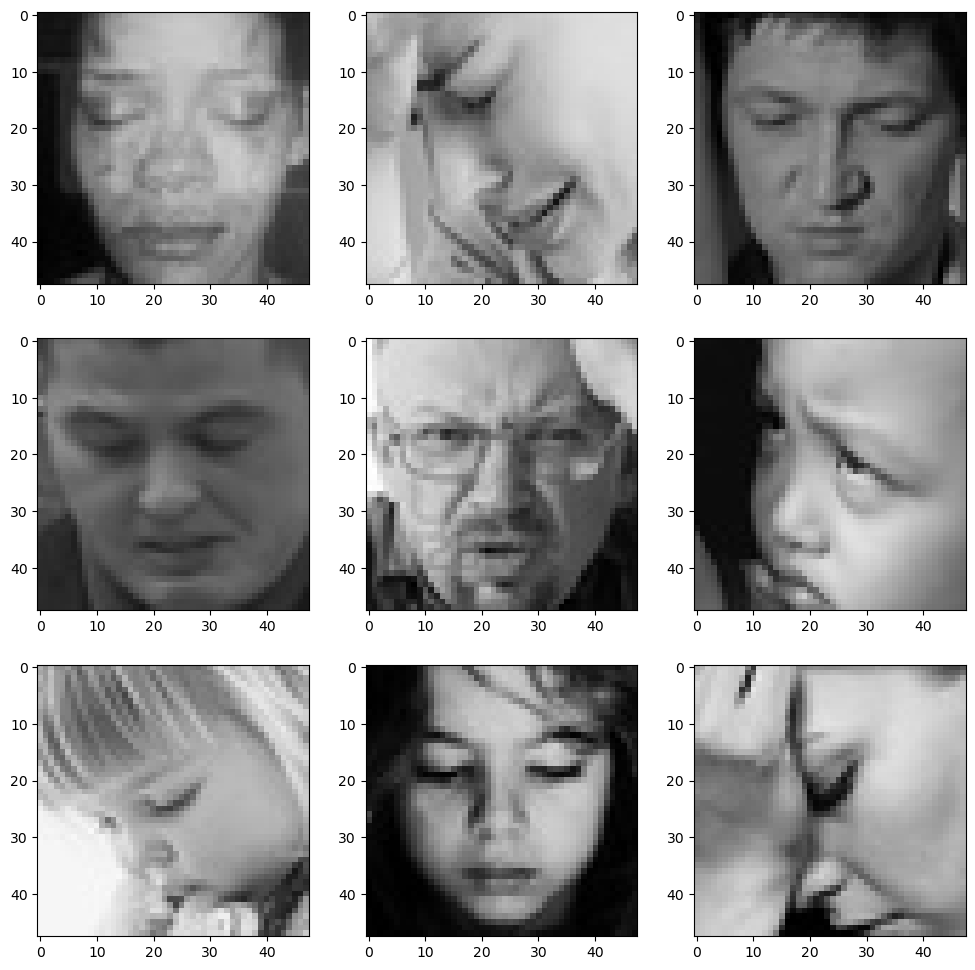

In [12]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
                # list of all files and directories in the specified directory.
    plt.imshow(img)   
plt.show()

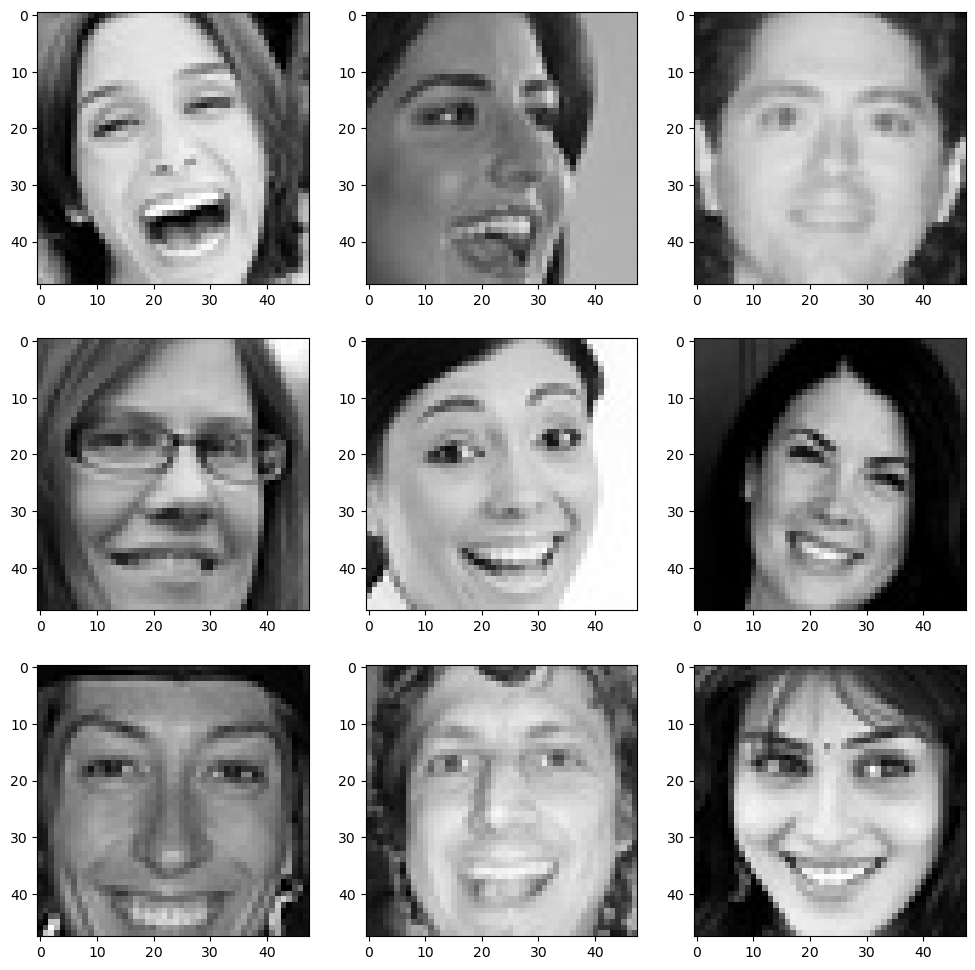

In [13]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

In [14]:
# TRAINING AND VALIDATION DATA GENERATION

batch_size  = 128 # in one iteration

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical', # 7 categories
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [6]:
#MODEL BUILDING

from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7 # possible outcomes

model = Sequential() # initializing the CNN 

# 1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1))) # 64 filter, 3 by 3 kernel size; 1 - grayscale image
model.add(BatchNormalization())
model.add(Activation('relu')) # only interprets positive part of its argument - rectified linear unit
model.add(MaxPooling2D(pool_size = (2,2))) # extracts important information
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

# 3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

# 4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) # collapse input to 1-D array

# Fully connected 1st layer
model.add(Dense(256)) #connecting layers using dense
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# FITTING THE MODEL WITH THE TRAINING AND VALIDATION DATA

from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath="./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [8]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/48
225/225 [==============================] - 817s 4s/step - loss: 1.7742 - accuracy: 0.3192 - val_loss: 1.6571 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 2/48
225/225 [==============================] - 799s 4s/step - loss: 1.4295 - accuracy: 0.4497 - val_loss: 1.3864 - val_accuracy: 0.4614 - lr: 0.0010
Epoch 3/48
225/225 [==============================] - 799s 4s/step - loss: 1.2808 - accuracy: 0.5073 - val_loss: 1.3020 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 4/48
225/225 [==============================] - 794s 4s/step - loss: 1.1985 - accuracy: 0.5395 - val_loss: 1.1884 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 5/48
225/225 [==============================] - 796s 4s/step - loss: 1.1254 - accuracy: 0.5725 - val_loss: 1.1421 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 6/48
225/225 [==============================] - 790s 4s/step - loss: 1.0816 - accuracy: 0.5913 - val_loss: 1.3144 - val_accuracy: 0.4923 - lr: 0.0010
Epoch 7/48
225/225 [==============================] - 804s 4s/st

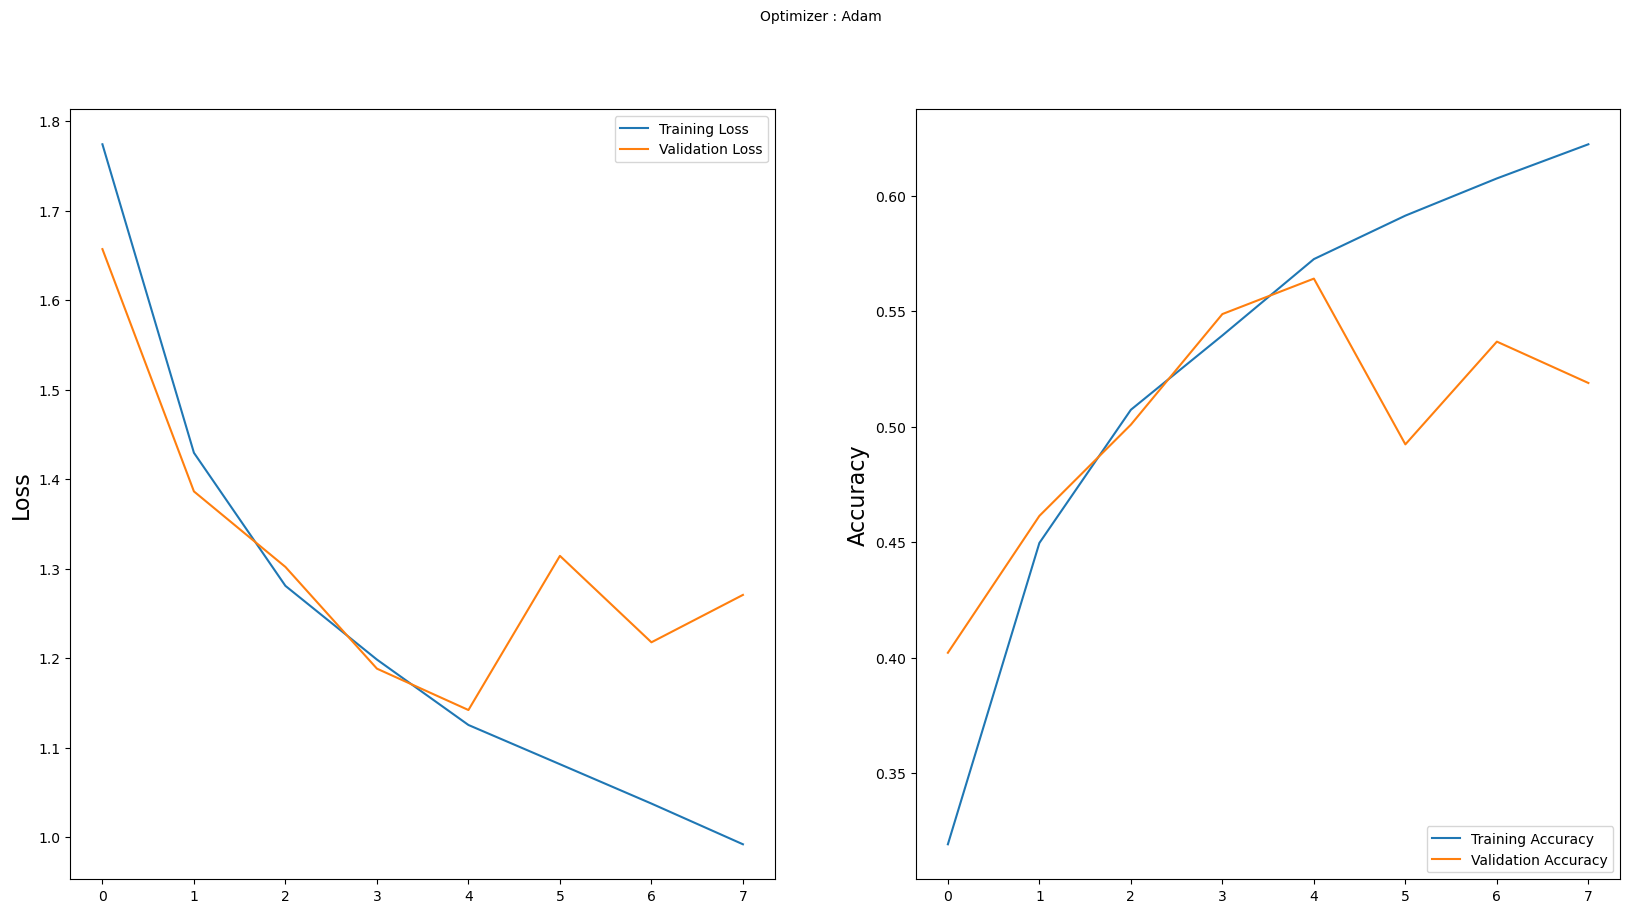

In [15]:
# PLOTTING ACCURACY AND LOSS

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()
